# Virtual Analog Filter Design

## Basic Blinear Transform

use one pole low rc pass

<img align="center" width=20% src="rc.png" alt>

$H_{a}$ detnotes the transfer function in s plane, $H_{d}$ detnotes the transfer function in z plane, transfer function of rc filter could be written in below's equation:

$$
\begin{align} 
H_{a}(s) 
&= \frac{ \frac{1}{Cs} }{ R + \frac{1}{Cs} }\\
&= \frac{1}{1 + RCs}
\end{align} 
$$

The bilinear transform took first order approximation, which is derive by Taylor series. There's other approach to make the approximation. In bewlow's equation, $T$ denotes the sample period which is also the inverse value of sample rate $fs$.

$$
s \leftarrow {\frac{2}{T}}{\frac{z-1}{z+1}}
$$

to convert this analog filter as a digital filter, applying bilinear transform by substituting $s$, then we can get the transfer function in z plane.

$$
\begin{align} 
H_{d}(z) 
&= H_{a}(\frac{2}{T} \frac{z-1}{z+1})\\
&= H_{a}(\frac{1}{1 + RC (\frac{2}{T} \frac{z-1}{z+1}) })\\
&= H_{a}(\frac{1+z}{(1+z) + RC (\frac{2(z-1)}{T}) })\\
&= H_{a}(\frac{1+z}{ \frac{T+Tz+2RCz-2RC}{T} })\\
&= H_{a}(\frac{1+z}{ \frac{(T-2RC)+(T+2RC)z}{T} })\\
&= H_{a}(\frac{1+z}{ (1-\frac{2RC}{T})+(1+\frac{2RC}{T})z })\\
&= H_{a}(\frac{1+z^{-1}}{ (1+\frac{2RC}{T})+(1-\frac{2RC}{T})z^{-1} })\\
\end{align} 
$$

below are the coefficients of digital rc filter, $b_{n}$ denotes the numerator of the linear filter, $a_{n}$ denotes the denominator of the linear filter.

$$
\begin{align} 
b_{0} &= 1 \\
b_{1} &= 1 \\
a_{0} &= 1+\frac{2RC}{T} \\
a_{1} &= 1-\frac{2RC}{T} \\
\end{align} 
$$

## Frequency Warping

in s plane the time is continous and the transfer function $H_{a}$ is evaluated at $s = j\omega_{a}$, but in z domain the time is discrete and the transfer function $H_{d}$ is evaluated at $z=e^{j\omega_{d}T}$.

$$
\begin{align} 
H_{d}(z) 
&= H_{a}(\frac{2}{T} \frac{z-1}{z+1})\\
&= H_{a}(\frac{2}{T} \frac{e^{j\omega_{d}T}-1}{e^{j\omega_{d}T}+1})\\
&= H_{a}(j \frac{2}{T} \cdot tan(\frac{\omega_{d}T}{2}))
\end{align} 
$$

now we could know the mapping equation between $\omega_{d}$ and $\omega_{a}$:

$$
\omega _{a} = {\frac {2}{T}} \cdot \tan({\frac{\omega _{d}T}{2}})
$$

In [1]:
import matplotlib.pyplot as plt
from scipy import signal, fft, interpolate
import numpy as np

In [2]:
fs = 44100                  # sampling rate
resistance = 100            # resistance, in the unit of ohm
capacitance = 100e-9        # capacitance, in the unit of farad
Ts = 1.0 / fs               # sampling rate interval
t = np.arange(0, 1, Ts)     # discrete time array
input_data = [0] * fs       # input data buffer
output_data = [0] * fs      # output data buffer
N = len(input_data)         # length of data

# 100nF 100e-9 farads
# 10nF 1e-8 farads
# 1nF 1e-9 farads

In [3]:
class vaLowPassRCFilter(object):
    def __init__(self, data, resistance, capacitance, Ts):
        self.r = resistance
        self.c = capacitance
        self.T = Ts
        self.initBuffer(input_data)
        self.initCoef()
        self.dispCutOffFreq()
    
    def initBuffer(self, input_data):
        self.x = input_data
        self.y = [0] * len(input_data)
        
    def initCoef(self):
        self.b0 = 1
        self.b1 = 1
        self.a0 = 1 + (2 * self.r * self.c)/self.T
        self.a1 = 1 - (2 * self.r * self.c)/self.T 

    def process(self):
        for i in range(len(self.x)):
            self.y[i] = (self.x[i] * self.b0)/self.a0 + (self.x[i - 1] * self.b1)/self.a0 - (self.y[i - 1] * self.a1)/self.a0
        return (self.y)

    def cutOffFreq(self):
        return (1 / (2 * np.pi * self.r * self.c))

    def warpingFreq(self):
        return (2 / self.T) * np.arctan(2 * np.pi * self.cutOffFreq() * self.T / 2) / (2 * np.pi)
    
    def dispCutOffFreq(self):
        print("analog cut-off frequency : " + str(self.cutOffFreq()) + " (hz)")
        print("warping cut-off frequency : " + str(self.warpingFreq()) + " (hz)")
        
    def coef(self):
        self.a0 = 1.0
        self._coef = {'a': [], 'b': []}
        self._coef['a'] = [self.a0, self.a1]
        self._coef['b'] = [self.b0, self.b1]
        return self._coef

In [4]:
input_data = np.random.normal(0, 1, size=fs)
filter_instance = vaLowPassRCFilter(input_data, resistance, capacitance, Ts)
output_data = filter_instance.process()

analog cut-off frequency : 15915.494309189537 (hz)
warping cut-off frequency : 11903.988054682102 (hz)


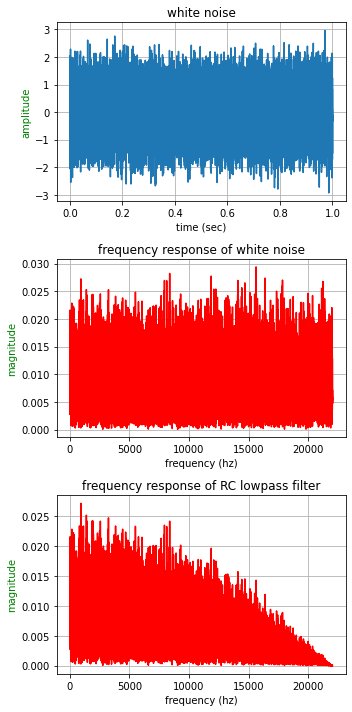

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))

axes[0].plot(t, output_data)
axes[0].set_xlabel('time (sec)')
axes[0].set_ylabel('amplitude', color='g')
axes[0].set_title('white noise')
axes[0].grid()

yf = fft.fft(input_data)
xf = fft.fftfreq(N, Ts)[:N//2]
axes[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]), 'r')
axes[1].set_title('frequency response of white noise')
axes[1].set_xlabel('frequency (hz)')
axes[1].set_ylabel('magnitude', color='g')
axes[1].grid()

yf = fft.fft(output_data)
xf = fft.fftfreq(N, Ts)[:N//2]
axes[2].plot(xf, 2.0/N * np.abs(yf[0:N//2]), 'r')
axes[2].set_title('frequency response of RC lowpass filter')
axes[2].set_xlabel('frequency (hz)')
axes[2].set_ylabel('magnitude', color='g')
axes[2].grid()

plt.tight_layout()
plt.show()

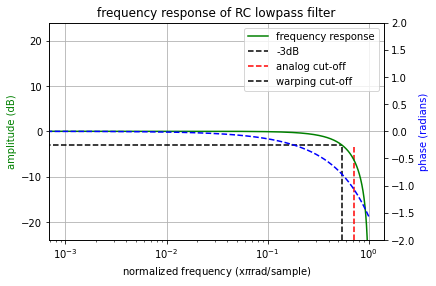

In [6]:
numerator = [filter_instance.b0, filter_instance.b1]
denominator = [filter_instance.a0, filter_instance.a1]
w, h = signal.freqz(numerator, denominator, worN=1024)

amplitude = 20 * np.log10(abs(h))
angle = np.angle(h)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-24, 24)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')
ax2.set_ylim(-2, 2)

l1 = ax1.hlines(-3, 0, filter_instance.warpingFreq()/(fs/2), color='k', linestyle='--', label='-3dB')
l2 = ax1.vlines(filter_instance.cutOffFreq()/(fs/2), -24, -3, color='r', linestyle='--', label='analog cut-off')
l3 = ax1.vlines(filter_instance.warpingFreq()/(fs/2), -24, -3, color='k', linestyle='--', label='warping cut-off')
ax1.legend(labels=["frequency response",l1.get_label(),l2.get_label(),l3.get_label()])

plt.title('frequency response of RC lowpass filter')
plt.xscale("log")
plt.show()

In [7]:
print("array we're interesting to apply interpolation:")
print(amplitude[552], amplitude[553])
print(w[552]/max(w)*fs/2, w[553]/max(w)*fs/2)

array we're interesting to apply interpolation:
-2.9993020529272583 -3.0127162754464676
11897.947214076246 11919.501466275658


In [8]:
yToFind = -3
yreduced = np.array(amplitude) - yToFind
freduced = interpolate.UnivariateSpline(w/max(w), yreduced, s=0)

print("Frequency at -3dB Cut-Off Point: ",freduced.roots()[0] * fs / 2, "(hz)")
print("Frequency from warping equation: ",filter_instance.warpingFreq(), "(hz)")

Frequency at -3dB Cut-Off Point:  11899.070540593348 (hz)
Frequency from warping equation:  11903.988054682102 (hz)


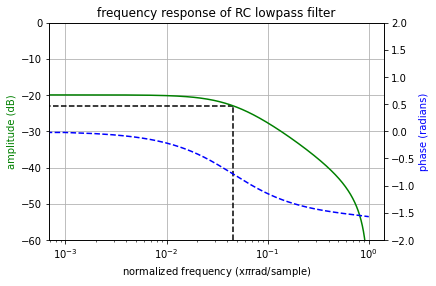

In [9]:
numerator = [0.0067, 0.0067]
denominator = [1, -0.8667]
w, h = signal.freqz(numerator, denominator, worN=1024)

amplitude = 20 * np.log10(abs(h))
angle = np.angle(h)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-60, 0)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')
ax2.set_ylim(-2, 2)

l1 = ax1.hlines(-23, 0, 1000/(fs/2), color='k', linestyle='--', label='-3dB')
l2 = ax1.vlines(1000/(fs/2), -60, -23, color='k', linestyle='--', label='analog cut-off')

plt.title('frequency response of RC lowpass filter')
plt.xscale("log")
plt.show()